In [1]:
import sys
sys.path.append('/Users/vedantchandra/0_research/software/starwave/')
import starwave

import numpy as np
import matplotlib.pyplot as plt
import bz2
import pandas as pd
from matplotlib.colors import LogNorm
import torch
from sbi import utils


plt.style.use('vedant')

### Load Isochrones

In [2]:
with bz2.BZ2File('/Users/vedantchandra/0_research/02_starwave/DATA/LMC_2022/isolib_LMC_df_corr.pbz2') as f:
    isodf = pd.read_pickle(f)

In [3]:
len(isodf)

6400177

In [4]:
# SWAP incorrect colors

# isodf['F160W_new'] = isodf['F110W']
# isodf['F110W'] = isodf['F160W']
# isodf['F160W'] = isodf['F160W_new']

### Load Artifical Stars

In [5]:
with bz2.BZ2File('/Users/vedantchandra/0_research/02_starwave/DATA/LMC_2022/AScat.pbz2') as f:
    asdf = pd.read_pickle(f)
asdf = pd.DataFrame(asdf)

In [6]:
# Rename to correct format, remove undetected stars

print(len(asdf))
detected = np.array(asdf['AS_det'])
asdf['F110W_in'] = asdf['AS_mag1_in']
asdf['F110W_out'] = asdf['AS_mag1_out']

asdf['F160W_in'] = asdf['AS_mag2_in']
asdf['F160W_out'] = asdf['AS_mag2_out']

asdf['F110W_out'].loc[~detected] = np.nan
asdf['F160W_out'].loc[~detected] = np.nan

2400000


/var/folders/6d/8w3sw49j3715htmfyjnsf0zh0000gn/T/ipykernel_5316/674033317.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asdf['F110W_out'].loc[~detected] = np.nan
/var/folders/6d/8w3sw49j3715htmfyjnsf0zh0000gn/T/ipykernel_5316/674033317.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asdf['F160W_out'].loc[~detected] = np.nan


Text(0, 0.5, '$F160W$')

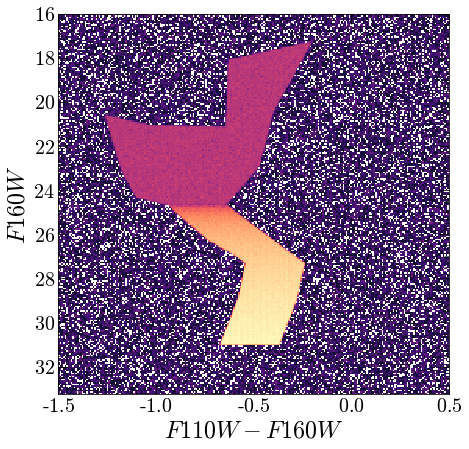

In [7]:
plt.hist2d(asdf['F110W_in'] - asdf['F160W_in'], asdf['F160W_in'],
          bins = 250, norm = LogNorm());

plt.gca().invert_yaxis()
plt.xlabel('$F110W - F160W$')
plt.ylabel('$F160W$')

Text(0, 0.5, '$F160W$')

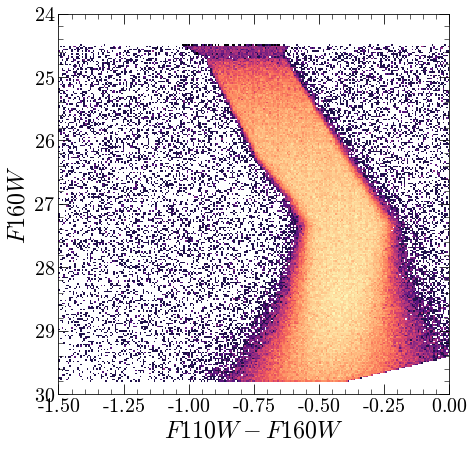

In [8]:
plt.hist2d(asdf['F110W_out'] - asdf['F160W_out'], asdf['F160W_out'],
          bins = 250, norm = LogNorm(),
          range = ((-1.5, 0), (24, 30)));

plt.gca().invert_yaxis()
plt.xlabel('$F110W - F160W$')
plt.ylabel('$F160W$')

### Load SFH Grid

In [9]:
with bz2.BZ2File('/Users/vedantchandra/0_research/02_starwave/DATA/LMC_2022/SFH_2d_frommarginals_metalbound.pbz2') as f:
    sfh_grid = pd.read_pickle(f)

### Load HST LMC Data

In [10]:
with bz2.BZ2File('/Users/vedantchandra/0_research/02_starwave/DATA/LMC_2022/catalog.pbz2') as f:
    lmc = pd.read_pickle(f)
lmc = pd.DataFrame(lmc)

lmc = lmc[lmc['dat_det']]

In [11]:
lmc['F110W'] = lmc['dat_mag1']
lmc['F160W'] = lmc['dat_mag2']

Text(0, 0.5, '$F160W$')

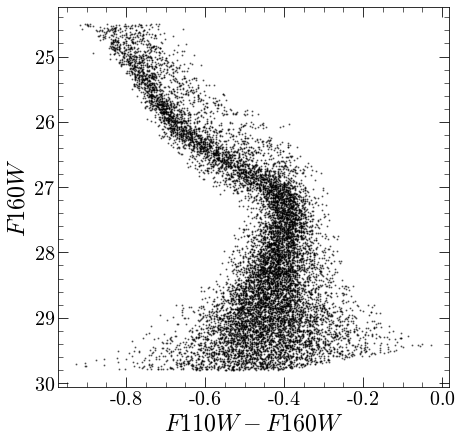

In [12]:
plt.scatter(lmc['F110W'] - lmc['F160W'], lmc['F160W'], s = 1, alpha = 0.5, color = 'k')

plt.gca().invert_yaxis()

plt.xlabel('$F110W - F160W$')
plt.ylabel('$F160W$')

In [13]:
shortbands = ['F160W', 'F110W']

### Setup starwave

In [14]:
print(np.min(isodf.index.get_level_values('age')))

print(np.max(isodf.index.get_level_values('age')))

0.5
15.815


In [15]:
print(sfh_grid['ages'].min())

0.0


In [16]:
print(sfh_grid['ages'].max())

13.4


In [17]:
shortbands

['F160W', 'F110W']

In [ ]:
sw = starwave.StarWave(isodf = isodf, asdf = asdf, imf_type = 'spl',
                      bands = shortbands, band_lambdas = [15369., 11534.],
                       sfh_type = 'grid', sfh_grid = sfh_grid)

interpolating 224 ages and 16 metallicities...


179it [00:28,  6.48it/s]

In [ ]:
logint = 4.8
slope = -2.5

sw.params['dm'].set(value = 18.52, fixed = True, bounds = [18, 19])
sw.params['log_int'].set(value = logint, bounds = (logint - .5, logint + .25))
sw.params['bf'].set(value = 0.4, fixed = True)
sw.params['slope'].set(value = slope, bounds = (-4, -1))

sw.params['av'].set(value = 3.1 * 0.075, bounds = (0, 1), fixed = True)
#sw.params['av'].set(value = 0 * 0.075, bounds = (0, 1), fixed = True)

In [ ]:
sw.params

In [ ]:
# Plot LMC and sampled CMD

lmc_mags = np.vstack((lmc[shortbands[0]], lmc[shortbands[1]])).T
#lmc_mags += exts # extinction correction
lmc_cmd = sw.make_cmd(lmc_mags)

params = torch.tensor([logint, -2.3])
eg_cmd = sw.sample_cmd(params, model = 'spl')[1]


# RESET 
#lmc_cmd = eg_cmd.copy()

starwave.plot_cmd(lmc_cmd, bands = shortbands)
starwave.plot_cmd(eg_cmd, bands = shortbands)

plt.gca().invert_yaxis()

### Run Starwave

In [ ]:
posteriors = sw.fit_cmd(eg_cmd, cores = 1, n_sims = 100, n_rounds = 3, gamma = None, 
                       gamma_kw = dict(q = 0.68, NN = 5, fac = 1))

In [ ]:
import sbi

In [ ]:
posterior = sw.posteriors[-1]

In [ ]:
print(posterior)

In [ ]:
posterior_samples = posterior.sample((1000000,), x = sw.obs)

In [ ]:
from sbi.analysis import pairplot

In [ ]:
_ = pairplot(posterior_samples, 
                   fig_size=(10,10))

In [ ]:
import corner

In [ ]:
f = corner.corner(np.array(posterior_samples), show_titles = True, 
                  labels = list(sw.param_mapper.keys()), title_kwargs = dict(fontsize = 14))
                 #truths = [logint, slope])